<a href="https://colab.research.google.com/github/anaguilarar/drone_data/blob/master/cloud_points_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/anaguilarar/drone_data.git

Cloning into 'drone_data'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 90 (delta 35), reused 70 (delta 17), pack-reused 0
Unpacking objects: 100% (90/90), done.


In [8]:
!cd drone_data

In [14]:
!pip install geopandas
!pip install rasterio
!pip install rasterstats

     |████████████████████████████████| 130 kB 36.8 MB/s 


In [1]:
import os
os.chdir('drone_data')

In [2]:
import geopandas as gpd

from utils.xyz_functions import CloudPoints, calculate_leaf_angle
from utils.plt_functions import plot_3d_cloudpoints


## Cloud Points

In this example, we are going to explore the different functions that have been developed for reading an XYZ file, and to create 3D models and leaf angle metrics for a single plant.

In order to use this script, it will be necessary to have at least one XYZ type file and one vector file (shp) referring to the region of interest, which means the polygon that frame plant

### Reading a single or multiple XYZ files

Here we are going to use a function named CloudPoints, this has as requirements the XYZ files path and a geopandas dataframe that contains the region of interest.CloudPoints



In [3]:
### read the region of interest as geopandas
roi = gpd.read_file("data/plant_frame.shp")

## here we specify the location of all the xyz files that we want to read
xyz_filenames = ["data/xyz_toyset_rgb_210922.xyz",
                 "data/xyz_toyset_rgb_210929.xyz"]

## The output will contains a list of geopandas dataframes
plant_cloudpoints = CloudPoints(xyz_filenames, roi.loc[0,'geometry'])

plant_cloudpoints.cloud_points[0].head()


,0,1,2,3,4,5,geometry
90162,368138.872,3956091.753,96.274,30,28,26,POINT (368138.872 3956091.753)
90185,368138.872,3956091.845,96.301,15,14,16,POINT (368138.872 3956091.845)
90216,368138.872,3956091.775,96.272,8,7,8,POINT (368138.872 3956091.775)
90298,368138.872,3956092.046,96.366,30,28,28,POINT (368138.872 3956092.046)
90500,368138.872,3956091.668,96.267,60,53,49,POINT (368138.872 3956091.668)


### 2D Visualizations

Once the data was read, we can create different plots. Here we will create a graphic to visualize our plant (Chinese cabbage) in a 2D graphic either plotting the plant from its front or its side. 

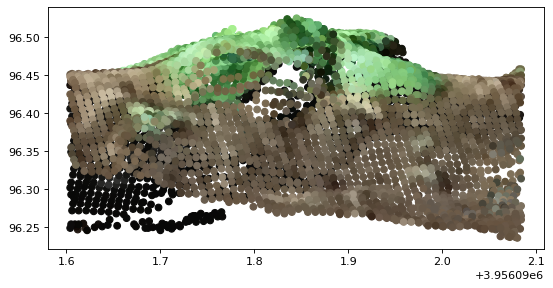

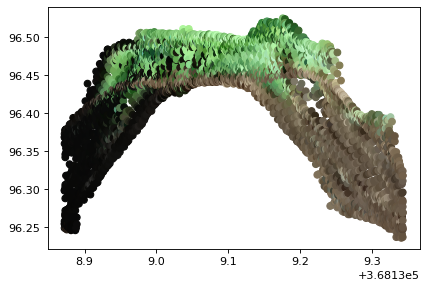

In [4]:
plant_cloudpoints.plot_2d_cloudpoints(index = 1, figsize= (8,4))
plant_cloudpoints.plot_2d_cloudpoints(index = 1, xaxis = "longitude", figsize= (6,4))

### Rasterize data

Now we have the data as points, but we can create tranform this data into a raster image. This will help not only for save memory space, but also will allow to stack multiples dates. The output will be a raster transformed as three dimensionals (date, x and y) xarray format. Likewise, the variables are going to be the z values and the RGB cloumns.

In [5]:
plant_raster = plant_cloudpoints.to_xarray()
plant_raster

<xarray.Dataset>
Dimensions:  (date: 2, x: 49, y: 50)
Coordinates:
  * x        (x) float64 3.681e+05 3.681e+05 3.681e+05 ... 3.681e+05 3.681e+05
  * y        (y) float64 3.956e+06 3.956e+06 3.956e+06 ... 3.956e+06 3.956e+06
Dimensions without coordinates: date
Data variables:
    z        (date, y, x) float32 0.0 96.26 96.28 96.27 0.0 ... 0.0 0.0 0.0 0.0
    red      (date, y, x) uint8 0 68 22 10 0 22 30 0 25 23 ... 0 0 0 0 0 0 0 0 0
    green    (date, y, x) uint8 0 59 22 10 0 21 29 0 23 21 ... 0 0 0 0 0 0 0 0 0
    blue     (date, y, x) uint8 0 54 22 11 0 22 29 0 24 21 ... 0 0 0 0 0 0 0 0 0
Attributes:
    transform:  | 0.01, 0.00, 368138.87|\n| 0.00, 0.01, 3956091.60|\n| 0.00, ...
    crs:        32654
    width:      49
    height:     50
    nodata:     0
    count:      5

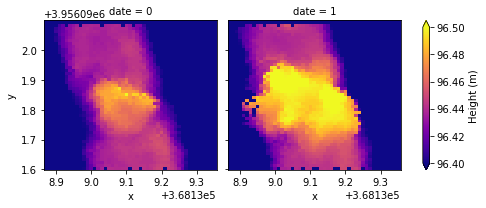

In [20]:
heightdata = plant_raster.z.isel(date=slice(0, 2)).copy()

g = heightdata.plot.pcolormesh( "x",
                "y",
                col="date",
                robust=True,
                cmap="plasma",
                cbar_kwargs={"label": "Height (m)"},
                vmin=96.4
                )

In [21]:
### 3D plot
plot_3d_cloudpoints(plant_raster.isel(date = 1).copy(),scale_xy=1)

### Calculate Leaf angle

Aimed at providing different kinds of metrics that can characterize the plant, we have added a function that can calculate the leaf angle reading from the center of the region of interest to each point.


In [6]:
plant_cloudpoints.remove_baseline()


In [8]:
plot_3d_cloudpoints(plant_cloudpoints.to_xarray().isel(date = 1).copy(),scale_xy=100)


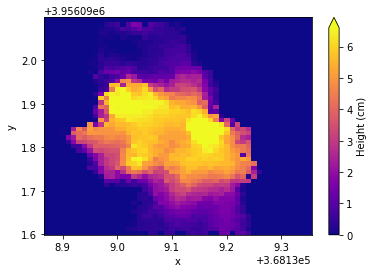

In [13]:
plant_raster = plant_cloudpoints.to_xarray()
heightdata = plant_raster.z.isel(date=1).copy()

g = heightdata.plot.pcolormesh( "x",
                "y",
                robust=True,
                cmap="plasma",
                cbar_kwargs={"label": "Height (cm)"},
                vmin=0
                )

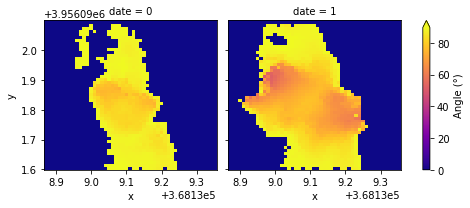

In [9]:
plant_raster_bsl = plant_cloudpoints.to_xarray()
plant_raster_bsl = calculate_leaf_angle(plant_raster_bsl)

angledata = plant_raster_bsl.leaf_angle.isel(date=slice(0, 2)).copy()

g = angledata.plot.pcolormesh( "x",
                "y",
                col="date",
                robust=True,
                cmap="plasma",
                cbar_kwargs={"label": "Angle (°)"}
                )
                